# The modified STACY facility using AGORA geometry

The modified STACY facility is an installation designed to perform critical experiments. 
It is constituted of a square lattice of identical fuel pins, immersed in a cylindrical water tank. Criticality is approached by varying the water level in the cylindrical tank. 

In the following, a simplified model of the experiment is built. It is demonstrated how the Python API of TRIPOLI-5 can be used to perform several successive simulations, in search for the critical water level in the experiment for a given lattice configuration. 

Information about the STACY experiment and its associated model were kindly provided by JAEA. For more details about the STACY experiment and the geometrical model used in the present example, please refer to :

S. Gunji, et al., *Study on the specifications of the basic core configurations of the modified STACY* Annals of Nuclear Energy (209), 2024, 110783.


In [1]:
%load_ext wurlitzer
import matplotlib; matplotlib.set_loglevel("critical")  # suppress "Matplotlib is building the font cache" message

In [2]:
import tripoli5 as t5

import matplotlib.pyplot as plt
import numpy as np

## Materials definition

In [3]:
# Temperature data will be provided in Kelvin
from tripoli5.core.literals import K

## Define a catalog file (equivalent to defining the acefile in other MC codes)
## In the present case, the catalog associated to the environment variable T5_CATALOG_PATH is used
catalog = t5.delos.Catalog.fromEnvVariable()

mixtures = []

# declare material with name "FUEL" (UO2 at 5% w.t. enrichment)
fuel = t5.materials.MixtureBuilder("concentrations")
fuel = fuel.withName("FUEL")
fuel = fuel.withTemperature(294 * K)
fuel = fuel.withCatalog(catalog)
fuel = fuel.add("U234", 1.1650e-05)
fuel = fuel.add("U235", 1.1554e-03)
fuel = fuel.add("U238", 2.1746e-02)
fuel = fuel.add("O16", 4.5913e-02)
fuel = fuel.build()

mixtures.append(fuel)

## a alternate and condensed way to build a material
water = (
    t5.materials.MixtureBuilder("concentrations")
    .withName("WATER")
    .withTemperature(294 * K)
    .withCatalog(catalog)
    .add("H1_H2O", 6.6648e-02)
    .add("H2_D2O", 9.9987e-06)
    .add("O16", 3.3329e-02)
    .build()
)
mixtures.append(water)

## Note the use of natural abundances, extracted from an external database
zircalloy = (
    t5.materials.MixtureBuilder("concentrations")
    .withName("CLAD")
    .withTemperature(294 * K)
    .withCatalog(catalog)
    .withNaturalAbundances(t5.materials.NaturalAbundances.fromNUBASE2020())
    .add("SN", 4.2e-06)
    .add("FE", 1.36e-04)
    .add("CR", 6.99e-05)
    .add("O", 3.18e-04)
    .add("C", 4.27e-05)
    .add("ZR", 2.185e-02)
    .build()
)
mixtures.append(zircalloy)

air = (
    t5.materials.MixtureBuilder("concentrations")
    .withName("AIR")
    .withTemperature(294 * K)
    .withCatalog(catalog)
    .withNaturalAbundances(t5.materials.NaturalAbundances.fromNUBASE2020())
    .add("N", 3.9e-05)
    .add("O", 1.0e-05)
    .build()
)
mixtures.append(air)

# Declare the collection of materials and build the nuclear data
media = t5.materials.NeutronMediumBuilder()
media = media.withCatalog(catalog)
media = media.withMixtures(mixtures)
media = media.build()

[2025-07-29 07:35:32.760] [info] Retrieving catalog data from environment variable T5_CATALOG_PATH.
[2025-07-29 07:35:32.760] [info] Loading catalog from file: /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/endfb8r0_mcnp_v2.2.0.yaml
[2025-07-29 07:35:32.784] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/mass/njoy_ace/v0.2.0/archive/wrapped_mass_data.bin
[2025-07-29 07:35:32.792] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/mass/njoy_ace/v0.2.0/archive/wrapped_mass_data.bin
[2025-07-29 07:35:32.793] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/mass/njoy_ace/v0.2.0/archive/wrapped_mass_data.bin
[2025-07-29 07:35:32.795] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/mass/njoy_ace/v0.2.0/archive/wrapped_mass_data.bin
[2025-07-29 07:35:32.797] [info] Building U234 at 294 [K], 2.5334957256000003e-08 [MeV], 20.850000000000023 [°C]
[2025-07-29 07:35:32.797] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/freegas/njoy_ace/v0.11.0/dir/U234.

## Geometry definition

The experiment consists of a square lattice of size 31x31 (pitch = 1.27 cm) immersed in a cylindrical tank partially filled with water. 

The fuel pins inserted in the lattice are identical and look something like this :

```text
  _______________________ z = 148.5
  |             |
  |             |        enveloppe
  |  _________  |
  |  | _____ |  |        air above fuel 
  |  | |   | |  |
  |  | |   | |  |        fuel + gap + clad
  |  | |   | |  | 
  |  | |   | |  |
  |  | |   | |  |
----------------------     water_height
  |  | |   | |  |
  |  | |   | |  |
  |  | |   | |  |         fuel + gap + clad
  |  | |   | |  |
  |  | |   | |  |
  |  |_|___|_|  |_________ z = 0 
  |             |         
  |             |         enveloppe      
  |_____________|_________ z = -1.5
```

A lattice of identical fuel pins is placed inside a water tank. The tank bottom is located at an abscissa of z = -21 cm. 

In this example, we model the lattice associated to the first critical experiments described in the reference provided above

In [4]:
## The experiment is made out of a 31x31 square lattice
##    1 : fuel pin         2 : empty lattice position

lattice_string = """
2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2
2 2 2 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 2 2
2 2 2 2 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 2 2 2
2 2 2 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 2 2
2 2 2 2 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 2 2 2
2 2 2 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 2 2 2
2 2 2 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 2
2 2 2 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 2 2 2
2 2 2 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 2
2 2 2 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 2 2 2
2 2 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 2 2
2 2 2 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 2 2 2
2 2 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 2 2
2 2 2 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 2 2 2
2 2 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 2 2
2 2 2 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 2 2 2
2 2 2 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 2
2 2 2 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 2 2 2
2 2 2 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 2
2 2 2 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 2 2 2
2 2 2 2 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 2 2 2
2 2 2 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 2 2
2 2 2 2 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 2 2 2
2 2 2 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 2 2
2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2
2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
"""

The overall geometry of the problem is made to depend on a global parameter, the water height inside the tank. 
To update the water level in the tank, the whole geometry is put inside a Python function, so that it can be re-uploaded at will.

Safeguards constraints on the experiment are such that one cannot perform a critcial experiment with water level lower than 40 cm or higher than 140 cm. To take this into account, the Python function returns `None` if the water level provided does not lie within these bounds. 

In [5]:
from tripoli5.core.euclide import Point, Vector
from tripoli5 import agora


## The geometry definition is put inside a function, to easily vary the water level
def make_stacy_geom(water_height, lattice_string):
    ## Make sure the water height is within the experiment tolerances
    ## This could also be used to make sure that the input value does not
    ## break the geometrical model
    if water_height < 40 or water_height > 140:
        return None

    ##  Main dimensions of the model
    z_min = -21  # lower and upper dimensions of the problem
    z_max = 148.5

    r_fuel = 0.41  # ful, air gap and cladding radii
    r_gap = 0.42
    r_clad = 0.475

    r_max = 50  # outer radius

    ## bottom of the fuel pin lattice is at -1.5 cm
    ## so that the fuel pins all begin at z = 0 cm
    lattice_zmin = -1.5
    ###

    zpl_min = agora.ZPlane(z_min)
    zpl_max = agora.ZPlane(z_max)
    zpl_lat_min = agora.ZPlane(lattice_zmin)

    zpl_water_height = agora.ZPlane(water_height)

    zpl_fuel_bottom = agora.ZPlane(0.0)
    zpl_fuel_top = agora.ZPlane(142)
    zpl_air_above_top = agora.ZPlane(146)

    cylz_fuel = agora.ZCylinder(0.0, 0.0, r_fuel)
    cylz_gap = agora.ZCylinder(0.0, 0.0, r_gap)
    cylz_clad = agora.ZCylinder(0.0, 0.0, r_clad)

    ## ----------------------------
    ## --- Fuel pins under water
    ## ----------------------------
    ## Fuel
    fuel_below = agora.Shape(-cylz_fuel & +zpl_fuel_bottom)
    vol_fuel_below = agora.Volume(fuel_below, "FUEL")

    ## Gap
    gap_below = agora.Shape(-cylz_gap & +cylz_fuel & +zpl_fuel_bottom)
    vol_gap_below = agora.Volume(gap_below, "AIR")

    ## Clad
    clad_below = agora.Shape(
        (-cylz_clad & +cylz_gap & +zpl_fuel_bottom) | (-cylz_clad & -zpl_fuel_bottom)
    )
    vol_clad_below = agora.Volume(clad_below, "CLAD")

    ## Water
    vol_water_below = agora.Volume(agora.Shape(+cylz_clad), "WATER")

    u_fuel_pin_below = agora.Universe(
        [vol_fuel_below, vol_gap_below, vol_clad_below, vol_water_below]
    )

    ## ----------------------------
    ## --- Fuel pins above water
    ## ----------------------------
    ## Fuel
    fuel_above = agora.Shape(-cylz_fuel & -zpl_fuel_top)
    vol_fuel_above = agora.Volume(fuel_above, "FUEL")

    ## Gap
    gap_above = agora.Shape(
        (-cylz_gap & +cylz_fuel & -zpl_fuel_top)
        | (-cylz_gap & +zpl_fuel_top & -zpl_air_above_top)
    )
    vol_gap_above = agora.Volume(gap_above, "AIR")

    ## Clad
    clad_above = agora.Shape(
        (-cylz_clad & +cylz_gap & -zpl_air_above_top)
        | (-cylz_clad & +zpl_air_above_top)
    )
    vol_clad_above = agora.Volume(clad_above, "CLAD")

    ## Air
    vol_air_above = agora.Volume(agora.Shape(+cylz_clad), "AIR")

    u_fuel_pin_above = agora.Universe(
        [vol_fuel_above, vol_gap_above, vol_clad_above, vol_air_above]
    )

    air_above = agora.createInfinite(material="AIR")
    water_below = agora.createInfinite(material="WATER")

    ## LATTICE DEFINITION : square lattice with a 1.27 cm pitch
    lat_above = agora.RectLattice(
        Point(-19.685, -19.685, 0),
        Vector(1.27, 1.27, 0.0),
        31,
        31,
        0,
        universe=u_fuel_pin_above,
        outer_universe=air_above,
        label="stacy_lattice_above_crit_height",
    )

    lat_below = agora.RectLattice(
        Point(-19.685, -19.685, 0),
        Vector(1.27, 1.27, 0.0),
        31,
        31,
        0,
        universe=u_fuel_pin_below,
        outer_universe=water_below,
        label="stacy_lattice_below_crit_height",
    )

    ## set empty positions from the lattice_string variable given as input
    lattice_config = np.fromstring(lattice_string, sep=" ").reshape(31, 31)
    empty_positions = np.where(lattice_config == 2)

    for x, y in zip(empty_positions[0], empty_positions[1]):
        lat_below[x, y, 0] = water_below
        lat_above[x, y, 0] = air_above

    ## Define the boundary of the problem : the external tank
    cylz_tank = agora.ZCylinder(0, 0, r_max)

    tank_above = agora.Shape(-cylz_tank & zpl_water_height)
    ctank_above = agora.CompositeVolume(tank_above, filler=lat_above)

    tank_below = agora.Shape(-cylz_tank & zpl_lat_min & -zpl_water_height)
    ctank_below = agora.CompositeVolume(tank_below, filler=lat_below)

    tank_below_lat = agora.Shape(-cylz_tank & -zpl_lat_min)
    ctank_below_lat = agora.Volume(tank_below_lat, "WATER")

    u_tank = agora.Universe([ctank_above, ctank_below, ctank_below_lat])

    tank_region = -cylz_tank & zpl_min & -zpl_max
    tank_tot = agora.Shape(tank_region)
    tank_volume = agora.CompositeVolume(tank_tot, u_tank)

    ## outside of the geometry (particles entering this volume are killed)
    outside_volume = agora.Volume.outside(agora.Shape(-tank_region))

    root_universe = agora.Universe([tank_volume, outside_volume])
    geometry = agora.Geometry(root_universe)

    return geometry

### Plot geometry

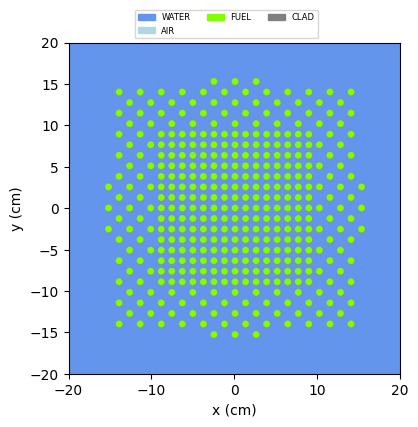

In [6]:
## Set water height at z = 60 cm
geo = make_stacy_geom(60, lattice_string)

# Plot XY cut view of the model at Z=20 cm
t5_plt = t5.geoplotter.GeoPlotterPyplot(geo)

frame = t5.geoplotter.Frame.fromMinMax(
    plane_cut="XY", altitude=50, u_min=-20, u_max=20, v_min=-20, v_max=20
)

## The color palette and colors are those available in the matplotlib library
_ = t5_plt.plot(
    frame=frame,
    color_map="Accent",
    mapping_colors={
        "WATER": "cornflowerblue",
        "FUEL": "chartreuse",
        "AIR": "lightblue",
        "CLAD": "grey",
    },
    resolution=100,
)

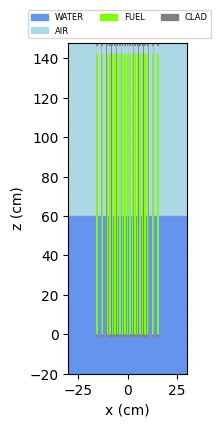

In [7]:
frame = t5.geoplotter.Frame.fromMinMax(
    plane_cut="XZ", altitude=0, u_min=-30, u_max=30, v_min=-20, v_max=148
)

_ = t5_plt.plot(
    frame=frame,
    color_map="Accent",
    mapping_colors={
        "WATER": "cornflowerblue",
        "FUEL": "chartreuse",
        "AIR": "lightblue",
        "CLAD": "grey",
    },
    resolution=100,
)

## Source definition 

In [8]:
## the fuel lattice total height is 142 cm (71x2)
src_space_distrib = t5.distributions.spatial.CylinderDistribution(
    Point(0.0, 0.0, 71.0), 15, 71
)
src_energy_distrib = t5.distributions.energy.MonoKinetic(
    t5.core.physics.Energy(2.0, t5.core.physics.Energy.Units.MeV)
)
src_angle_distrib = t5.distributions.angular.IsotropicAngularDistribution()

src = t5.source.FactorizedSource(
    src_space_distrib, src_energy_distrib, src_angle_distrib
)

## Sample Keff at different water heights

In [9]:
keff_vs_height = []

for sampled_height in range(46, 57):
    geo = make_stacy_geom(
        sampled_height, lattice_string
    )  ## paramater-dependent geometry

    ## Remember that a safeguard has been implemented in the function make_stacy_geom :
    ## if the provided water level does not fall within the experimental constraints, it returns None
    if geo is None:
        continue

    ## To change the random seed in each iteration of the loop,
    ## a different integer value must be passed to the simulationParameters object.
    ## In the present case, there's a natural candidate : the sampled water level,
    ## that increase by integrer increments
    simu_params = t5.simulation.SimulationParameters(
        nb_cycles=150,
        nb_events=10_000,  # Particles per cycle
        name="crit_height_search",
        nb_threads=20,
        discard=50,
        random_seed=sampled_height,  ## change random seed
    )

    ## initialize simulation object
    simu = (
        t5.simulation.SimulationBuilder(
            simulation_mode="criticality", parallelism_type="openmp"
        )
        .withMedia("neutron", media)
        .withSource(src)
        .withParameters(simu_params)
        .withGeometry(geo)
        .build()
    )
    simu.run()

    keff_vs_height.append(
        [sampled_height, simu.getScore(0).mean[0], np.sqrt(simu.getScore(0).var[0])]
    )

keff_vs_height = np.array(keff_vs_height)

[2025-07-29 07:35:55.783] [info] *** Beginning of simulation ***
[2025-07-29 07:35:55.785] [info] Cycle: 1 of 150
[2025-07-29 07:35:55.904] [info]   kstep = 0.45120
[2025-07-29 07:35:55.904] [info]   Mean number of collisions: 31.4594
[2025-07-29 07:35:55.904] [info] Cycle: 2 of 150
[2025-07-29 07:35:56.069] [info]   kstep = 0.77080
[2025-07-29 07:35:56.069] [info]   Mean number of collisions: 59.0105
[2025-07-29 07:35:56.069] [info] Cycle: 3 of 150
[2025-07-29 07:35:56.264] [info]   kstep = 0.94850
[2025-07-29 07:35:56.264] [info]   Mean number of collisions: 70.2411
[2025-07-29 07:35:56.264] [info] Cycle: 4 of 150
[2025-07-29 07:35:56.471] [info]   kstep = 0.96860
[2025-07-29 07:35:56.471] [info]   Mean number of collisions: 75.6458
[2025-07-29 07:35:56.472] [info] Cycle: 5 of 150
[2025-07-29 07:35:56.674] [info]   kstep = 0.98160
[2025-07-29 07:35:56.674] [info]   Mean number of collisions: 74.1052
[2025-07-29 07:35:56.675] [info] Cycle: 6 of 150
[2025-07-29 07:35:56.887] [info]   k

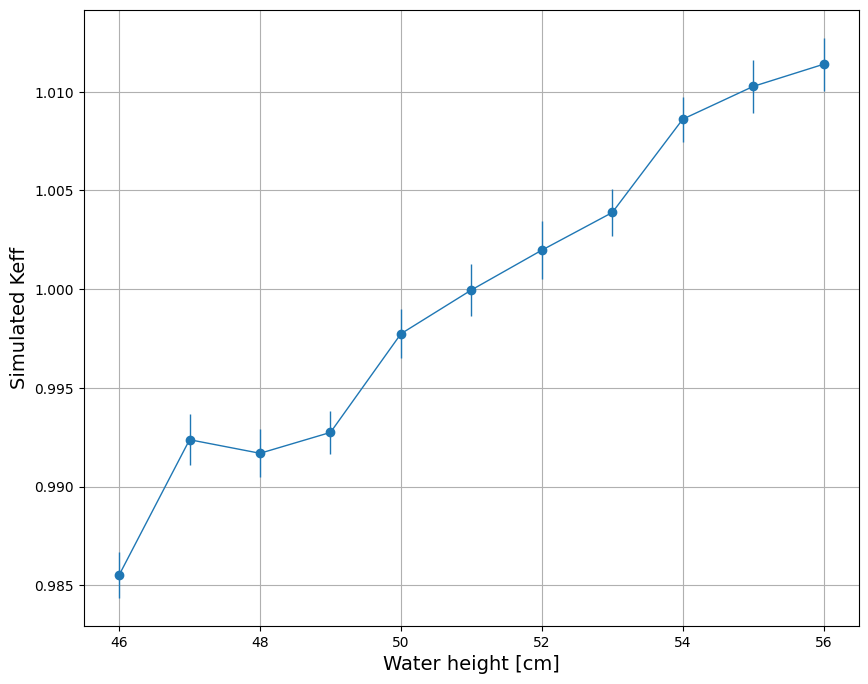

In [10]:
plt.figure(figsize=(10, 8))
plt.errorbar(
    keff_vs_height[:, 0],
    keff_vs_height[:, 1],
    yerr=keff_vs_height[:, 2],
    fmt="o-",
    lw=1,
)
plt.ylabel("Simulated Keff", fontsize=14)
plt.xlabel("Water height [cm]", fontsize=14)
plt.grid()
plt.show()

In [11]:
## sampled height, estimated Keff, estimated standard deviation on Keff
np.set_printoptions(precision=5, suppress=True)
print(keff_vs_height)

[[46.       0.98552  0.00115]
 [47.       0.99238  0.00128]
 [48.       0.99169  0.00122]
 [49.       0.99275  0.00108]
 [50.       0.99774  0.00124]
 [51.       0.99996  0.00131]
 [52.       1.00198  0.00148]
 [53.       1.00389  0.0012 ]
 [54.       1.00861  0.00114]
 [55.       1.01027  0.00132]
 [56.       1.0114   0.00134]]


In [12]:
## Interpolate the critical water level using the linear interpolation method interp from numpy
interp_crit_height = np.interp(1.0, keff_vs_height[:, 1], keff_vs_height[:, 0])
print(f"Interpolated critical height = {interp_crit_height:.1f} cm")

Interpolated critical height = 51.0 cm
